# Various Types of Finite Difference Advection Algorithms

The advection equation gives the flow of any quantity (mass, density, charge etc) on a velocity field. Advection equation in fluid dynamics can be represented by the following equation

$$\frac{d\rho}{dt}=-\nabla(\rho V)$$

where $\rho$ is the density, V is the velocity field. 
In one dimension the above equation can be written as,
$$\frac{d\rho}{dt}=-\frac{d(\rho V)}{dx}$$

### Central finite difference form

The above equation can be written in central finite difference form as
$$\frac{\rho_i^{t+1}-\rho_i^{t}}{dt}=\frac{\rho_{i+1}V_{i+1}-\rho_{i-1}V_{i-1}}{dx}$$

This graph is a intentionally left blank. We will use it to make animation in the later part of the program


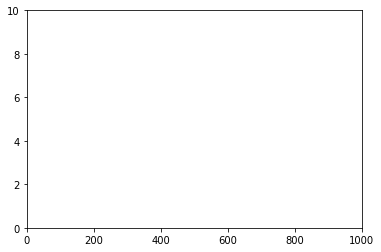

In [2]:
## Code to generate GIF image <source = "http://tiao.io/posts/notebooks/save-matplotlib-animations-as-gifs/">
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import animation, rc
from IPython.display import HTML
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots();


ax.set_xlim(( 0, 1000));
ax.set_ylim((-0, 10));
line, = ax.plot([], [], lw=2);

def sett(x1,x2,y1,y2):
    ax.set_xlim(( x1,x2));
    ax.set_ylim((y1, y2));
    line, = ax.plot([], [], lw=2);

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i,rho,xx,step):
    x = xx
    rr=step*i
    y = rho[rr]
    sett(xx.min(),xx.max(),rho[rr].min(),rho[rr].max())
    line.set_data(x, y)
    return (line,)
print("This graph is a intentionally left blank. We will use it to make animation in the later part of the program")

In [ ]:
spacegrid=1000
width=1.0
xx=np.arange(spacegrid)
timesteps=1000
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
dx=width/spacegrid
rho=np.zeros((timesteps,spacegrid),float)
rho[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)

for t in range(timesteps-1):
    #Explicit----------------------------------------------------------------------------------------
    rho[t+1,1:spacegrid-1]=rho[t,1:spacegrid-1]-dt*velocity*(rho[t,2:spacegrid]-rho[t,0:spacegrid-2])/(2*dx)
    #plt.plot(rho[t])
    #plt.show()
    #sett(0,1000,0,20)

anim = animation.FuncAnimation(fig, animate, fargs=(rho,xx,10,), init_func=init,frames=100, interval=200, blit=True)
anim.save('explicitt.gif', writer='imagemagick')
Image(url='explicitt.gif')

The above animation is the result of direct explicit solution of the continuity equation with 1000 time steps. We can see that the solution becomes immediately unstable and the square wave is completely lost within noise.

## Effect of small time-stepping (Increased stability but decreased speed)
Let us not decrease the time step 'dt' and execute the code again. Decreasing the time stepping makes the program very slow but makes the simulation result better.

In [ ]:
timesteps=100000
dt=simulationtime/timesteps
rho=np.zeros((timesteps,spacegrid),float)
rho[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)
for t in range(timesteps-1):
    rho[t+1,1:spacegrid-1]=rho[t,1:spacegrid-1]-dt*velocity*(rho[t,2:spacegrid]-rho[t,0:spacegrid-2])/(2*dx)

anim = animation.FuncAnimation(fig, animate, fargs=(rho,xx,1000,), init_func=init,frames=100, interval=200, blit=True)
anim.save('explicit_lessdt1.gif', writer='imagemagick')
Image(url='explicit_lessdt1.gif')

Here we increased the number of time stepping from 1000 to 100000 and executed the code again. We can now see the square wave travelling from left to right. But still the wave is not free from noise. Furthermore, increasing the time stepping makes the program more slow. 

## Implicit Central Finite difference form
The above continuity equation can be written in implicit finite difference form by taking density from the future time step as,

$$\frac{\rho_i^{t+1}-\rho_i^1}{dt} =\frac{\rho_{i+1}^{t+1}V_{i+1}-\rho_{i-1}^{t+1}V_{i-1}}{2dx}$$

which can be simplified to ,
$$\frac{dt}{2dx}\rho_{i-1}^{t+1}V_{i-1}+\rho_i^{t+1}-\frac{dt}{2dx}\rho_{i+1}^{t+1}V_{i+1}=\rho_i^t$$

This equation has to be solved at all grid points. The system of equations can be written in a matrix form

$$A\rho^{t+1}=\rho_t$$

Where A is a tridiagonal matrix with 1 on the main diagonal, $(dt/2dx)V_{i-1}$ on the diagonal below the main diagonal and $-(dt/2dx)V_{i+1}$ on the diagonal above the main diagonal.

In [6]:
def tridiagDense(r,nxp,k1=-1,k2=0,k3=1):
    a=np.ones(nxp-1)*(-r)
    b=np.ones(nxp)
    c=-1*a
    return np.diag(a,k1)+np.diag(b,k2)+np.diag(c,k3)

timesteps=101
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
rho=np.zeros((timesteps,spacegrid),float)
rho[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)
for t in range(timesteps-1):
    ep=velocity*(dt/(2*dx))
    IA=tridiagDense(ep,spacegrid)
    B=np.linalg.inv(IA)
    rho[t+1]=B.dot(rho[t])
    rho[t+1,0]=0;rho[t+1,-1]=0
anim = animation.FuncAnimation(fig, animate, fargs=(rho,xx,1,), init_func=init,frames=100, interval=200, blit=True)
anim.save('impliss.gif', writer='imagemagick')
Image(url='impliss.gif')

The above animation is the solution of the implicit central difference from. We can see that the graph is very stable till the wave reaches the right boundary, where it becomes unstable. Despite of being stable, the shape of the graph has changed from rectrangular to bell shaped. 

## Upwind Algorithm

In [5]:
timesteps=1000
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
veolcitygrid=velocity*np.ones(spacegrid)
zeromatrix=np.zeros((spacegrid),float)
rhoupwind=np.zeros((timesteps,spacegrid+2),float)
rhoupwind[0,30:300]=10
veolcitygrid=velocity*np.ones(spacegrid)
for t in range(timesteps-1):
    aplus=np.maximum(zeromatrix,veolcitygrid)
    aminus=np.minimum(zeromatrix,veolcitygrid)
    rhoplus=(rhoupwind[t,2:]-rhoupwind[t,1:-1])/dx
    rhominus=(rhoupwind[t,1:-1]-rhoupwind[t,:-2])/dx
    rhoupwind[t+1,1:-1]=rhoupwind[t,1:-1]-dt*(aplus*rhominus+aminus*rhoplus)
    #plt.plot(rhoupwind[t+1])
    #plt.show()0
anim = animation.FuncAnimation(fig, animate, fargs=(rhoupwind[:,1:-1],xx,10,), init_func=init,frames=100, interval=1, blit=True)
anim.save('upwind2.gif', writer='imagemagick', fps=10)
Image(url='upwind2.gif')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


###### Area under the curve
Here we use Trapezoidal rule to perform numerical integration such that the area under the curve can be calculated. 
The formula of numerical integration is 
$$\int_{x_1}^{x_n} f(d)dx=\frac{h}{2}\{f(x_1)+2f(x_2)+2f(x_3)+...2f(x_{n-1})+f(x_n)\}$$

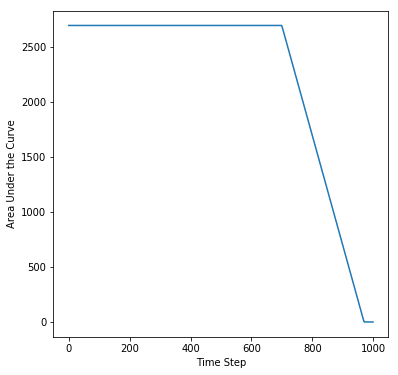

In [6]:
h=xx[2]-xx[1]
def areacalculation(timesteps,rhokovalue):
    area=np.zeros(timesteps,float)
    for cc in np.arange(timesteps):
        area[cc]=(h/2)*(rhokovalue[cc,0]+2*sum(rhokovalue[cc,1:999])+rhokovalue[cc,1000])
    plt.figure(figsize=(6,6))
    plt.plot(area)
    plt.xlabel("Time Step")
    plt.ylabel("Area Under the Curve")
    plt.show()
    
areacalculation(timesteps,rhoupwind)

From the above graph it can be seen that the area of the wave is conserved as it moves from left to right in the direction of velocity field.

## Validity of Upwind Scheme -- is it always conservative?

The above example is about the motion of square wave  on a uniform velocity field. The upwind scheme seems to perfectly solve the continuity equation for that example because the wave travels with being unstable(like in explicit scheme) and without changing its shape(like in implicit scheme) and also remains stable in the boundary. 

Let us now change the setup of our numerical experiment. We define a sinosuidal velocity field and put the square wave on the center of the 1D domain and run the above simulation again. 

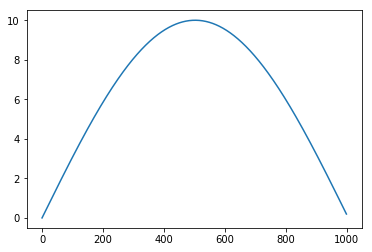

In [7]:
velocitygrid=10*np.sin(xx/320)
plt.plot(velocitygrid)

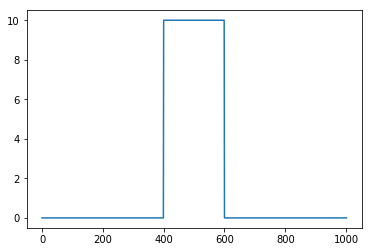

In [8]:
rhoupwind=np.zeros((timesteps,spacegrid+2),float)
rhoupwind[0,400:600]=10
plt.plot(rhoupwind[0])

In [9]:
timesteps=1000
simulationtime=1.0
velocity=1.0
dt=simulationtime/timesteps
velocitygrid=velocity*np.sin(xx/320)
zeromatrix=np.zeros((spacegrid),float)
rhoupwindV=np.zeros((timesteps,spacegrid+2),float)
rhoupwindV[0,400:600]=10
for t in range(timesteps-1):
    aplus=np.maximum(zeromatrix,velocitygrid)
    aminus=np.minimum(zeromatrix,velocitygrid)
    rhoplus=(rhoupwindV[t,2:]-rhoupwindV[t,1:-1])/dx
    rhominus=(rhoupwindV[t,1:-1]-rhoupwindV[t,:-2])/dx
    rhoupwindV[t+1,1:-1]=rhoupwindV[t,1:-1]-dt*(aplus*rhominus+aminus*rhoplus)
    #plt.plot(rhoupwind[t+1])
    #plt.show()
anim = animation.FuncAnimation(fig, animate, fargs=(rhoupwindV[:,1:-1],xx,10,), init_func=init,frames=100, interval=1, blit=True)
anim.save('upp4.gif', writer='imagemagick', fps=10)
Image(url='upp4.gif')

Through all these methods we were trying to solve the continuity equation with advection component only. Continuity equation is all about the conversation of certain quantities (mass, charge, etc.) but as we can see from the figure the area of the square wave is decreasing as it travels to the right. This is the violation of the essence of the continuity equation. 

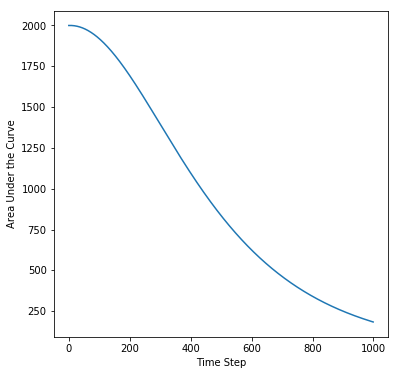

In [10]:
areacalculation(timesteps,rhoupwindV)

From the above graph we can see that the area of the curve is decreasing gradually. It shows that the upwind scheme is not conservative (the above solution violates the conservation of mass)

## Explicit finite difference by the definition of flux

Flux is the quanity passing through a surface per unit time. Flux at a grid point can be expressed as
$$flux_{i+\frac{1}{2}} = 0.5(V_{i+1}\rho_{i+1}+V_{i}\rho_{i})-0.5\frac{V_{i+1}+V_{i}}{2}(\rho_{i+1}-\rho{i})$$

So, the continuity equation reduces to the form,
$$\frac{d\rho}{dt}=\frac{d(Flux)}{dx}$$

Or,
$$\frac{\rho_i^{t+1}-\rho_i^t}{dt}=\frac{Flux_{i+1/2}-Flux_{i-1/2}}{dx}$$

Thus,
$$\rho_i^{t+1}=\rho_i^t-\frac{Flux_{i+1/2}-Flux_{i-1/2}}{dx}dt$$

#### a) For uniform velocity field 

In [ ]:
timesteps=1000
dt=simulationtime/timesteps
rhoFx=np.zeros((timesteps,spacegrid+4),float)
flux=np.zeros((spacegrid+2),float)
rhoFx[0,30:300]=10
veolcitygrid=100000*velocity*np.ones(spacegrid)
#plt.plot(rhoFx[0])
for t in range(timesteps-1):
    flux=(0.5*(velocity*rhoFx[t,1:]+velocity*rhoFx[t,:-1])-0.5*abs(velocity)*(rhoFx[t,1:]-rhoFx[t,:-1]))*dt
    rhoFx[t+1,1:-1]=rhoFx[t,1:-1]-(flux[1:]-flux[:-1])/dx
anim = animation.FuncAnimation(fig, animate, fargs=(rhoFx[:,2:-2],xx,10,), init_func=init,frames=100, interval=20, blit=True)
anim.save('explicitflux238.gif', writer='imagemagick')
Image(url='explicitflux238.gif')

From the above animation it can be seen that the explicit scheme written according to the definition of flux is very stable even when the time stepping is very high.

#### b) For Non-Uniform velocity field

In [12]:
timesteps=1000
dx=width/spacegrid
xx=np.arange(spacegrid+4)
velocitygrid=np.sin(xx/320)
dt=simulationtime/timesteps
rhoFxVar=np.zeros((timesteps,spacegrid+4),float)
rhoFxVar[0,300:600]=10
veolcitygrid=10*np.ones(spacegrid)
for t in range(timesteps-1):
    flux=(0.5*(velocitygrid[1:]*rhoFxVar[t,1:]+velocitygrid[:-1]*rhoFxVar[t,:-1])-0.5*0.5*abs(velocitygrid[1:]+velocitygrid[:-1])*(rhoFxVar[t,1:]-rhoFxVar[t,:-1]))*dt
    rhoFxVar[t+1,1:-1]=rhoFxVar[t,1:-1]-(flux[1:]-flux[:-1])/dx
anim = animation.FuncAnimation(fig, animate, fargs=(rhoFxVar[:,2:-2],xx[2:-2],10,), init_func=init,frames=100, interval=20, blit=True)
anim.save('explicitfluxVar22333.gif', writer='imagemagick')
Image(url='explicitfluxVar22333.gif')

#### Is the area under the curve conserved in this scheme?

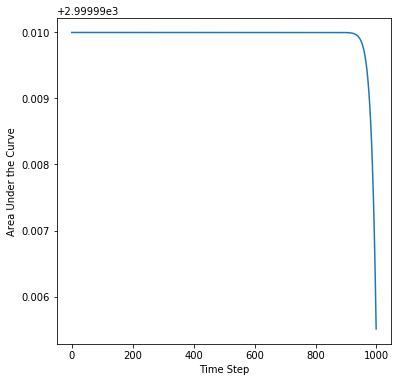

In [13]:
areacalculation(timesteps,rhoFxVar)

From the above graph we can see that the area under density($\rho$) vs position is always constant, unless the wave passes the right boundary of the domain. So the finite difference form of continuity equation written in flux form is conservative. 

## Implicit Finite Difference by the difinition of flux

In [14]:
#def SparseImplicitOp(dx,dt,vi,k1=-1,k2=0,k3=1):
k1=-1;k2=0;k3=1
import numpy as np
import sys
import scipy.sparse.linalg as la
import scipy.sparse as sparse
vx=np.ones(5)
nx=vx.size
d1=np.zeros((nx),float)
d2=np.ones((nx),float)
d3=np.zeros((nx),float)
d1[:-2]=-(dt/dx)*((1/4)*v[:-2]+(1/4)*v[1:-1]-(1/2)*v[:-2])
d2[1:-1]=(1+(dt/dx)*(0.5*v[1:-1]+0.25*v[2:]+0.25*v[1:-1]-0.5*v[1:-1]+0.25*v[1:-1]+0.25*v[:-2]))
d3[2:]=3#-(dt*graddif/(2*dx)+dt*dif[1:-1]/(dx**2))+dt*(avP/(2*dx)-vi[2:]/(2*dx))
#return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )
sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc().todense()

NameError: name 'v' is not defined

In [17]:
import numpy as np
def SparseContinuityOperator22(dt,dx,vi,k1=-1,k2=0,k3=1):
    nx=vi.size
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=(dt/dx)*(0.75*vi[:-2]+0.25*vi[1:-1])
    d2[1:-1]=(1-(dt/dx)*(0.25*vi[:-2]+0.5*vi[1:-1]+0.25*vi[2:]))
    d3[2:]=(dt/dx)*(0.25*vi[1:-1]-0.25*vi[2:])
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )


In [46]:
def SparseContinuityOperator(dx,dt,vi,k1=-1,k2=0,k3=1):
    nx=vi.size
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    avM=0.5*(vi[:-2]+vi[1:-1])
    avP=0.5*(vi[1:-1]+vi[2:])
    d1[:-2]=dt*avM/(2*dx)+dt*vi[0:-2]/(2*dx)
    d2[1:-1]=dt*(-avM/(2*dx)+vi[1:-1]/(2*dx)-avP/(2*dx)-vi[1:-1]/(2*dx))
    d3[2:]=dt*(avP/(2*dx)-vi[2:]/(2*dx))
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )


In [44]:
print(difOperatorElectron1.todense())

[[  1.   0.   0. ...   0.   0.   0.]
 [ 10. -10.   0. ...   0.   0.   0.]
 [  0.  10. -10. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -10.   0.   0.]
 [  0.   0.   0. ...  10. -10.   0.]
 [  0.   0.   0. ...   0.   0.   1.]]


In [64]:
def SparseContinuityOperator22(dt,dx,vi,k1=-1,k2=0,k3=1):
    nx=vi.size
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=(dt/dx)*(-0.75*vi[:-2]-0.25*vi[1:-1])
    d2[1:-1]=(1+(dt/dx)*(0.25*vi[:-2]+0.5*vi[1:-1]+0.25*vi[2:]))
    d3[2:]=(dt/dx)*(0.25*vi[1:-1]-0.25*vi[2:])
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )

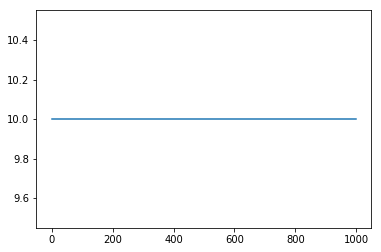

[[  1.   0.   0. ...   0.   0.   0.]
 [-10.  11.   0. ...   0.   0.   0.]
 [  0. -10.  11. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  11.   0.   0.]
 [  0.   0.   0. ... -10.  11.   0.]
 [  0.   0.   0. ...   0.   0.   1.]]
(1000, 1000)


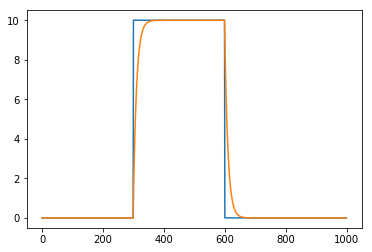

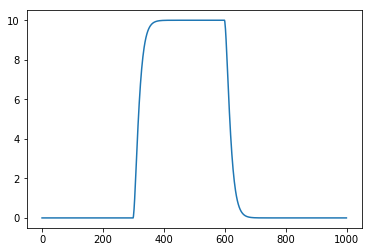

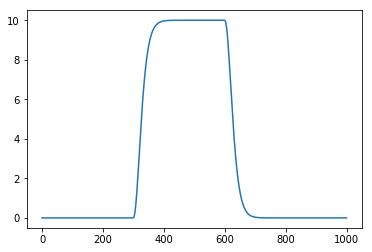

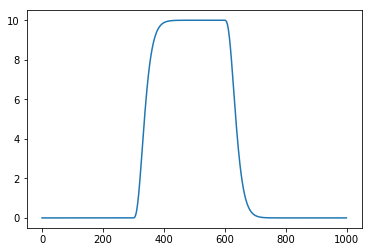

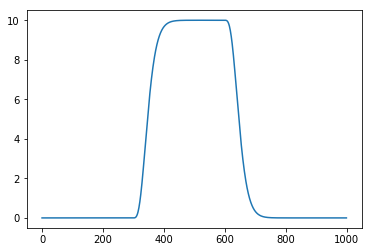

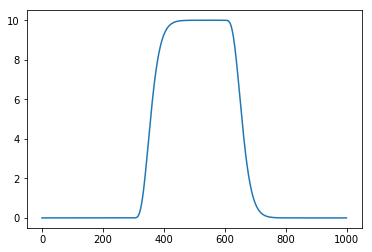

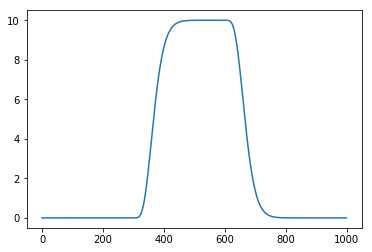

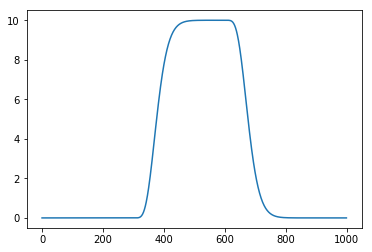

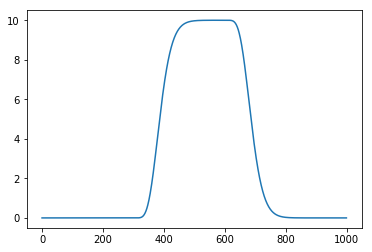

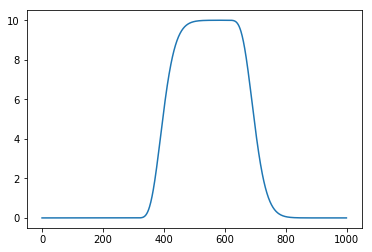

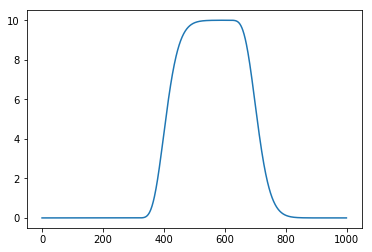

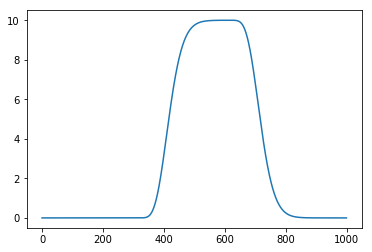

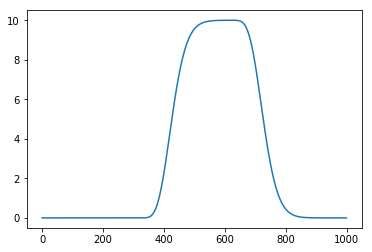

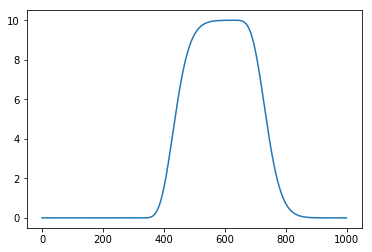

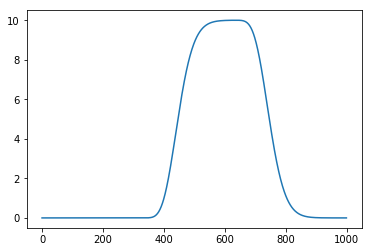

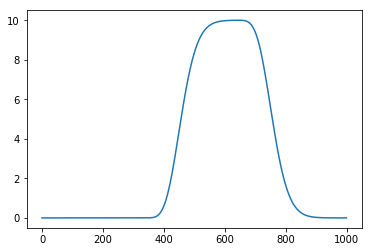

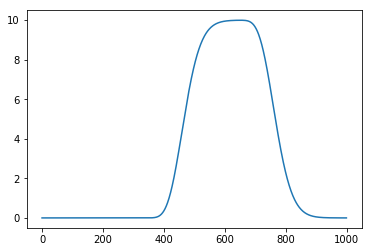

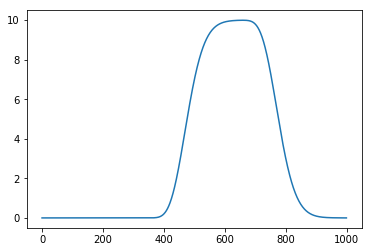

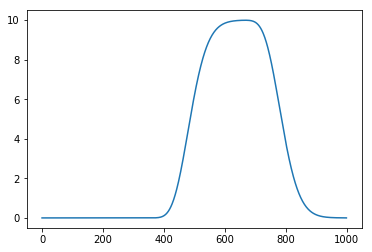

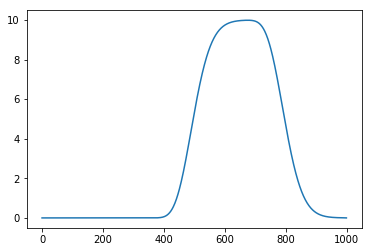

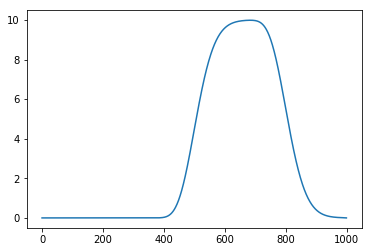

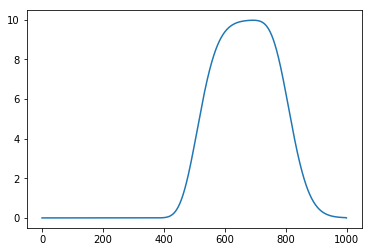

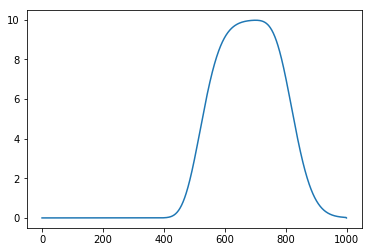

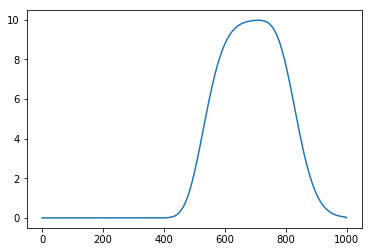

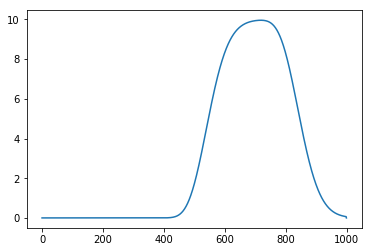

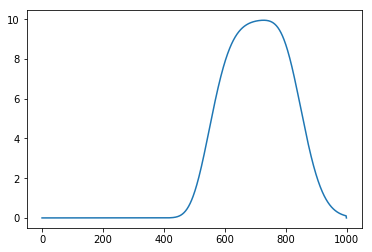

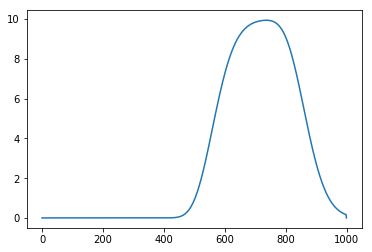

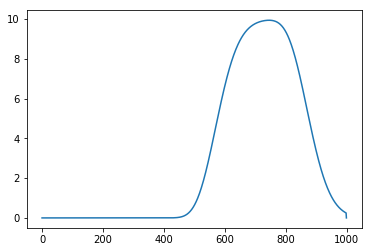

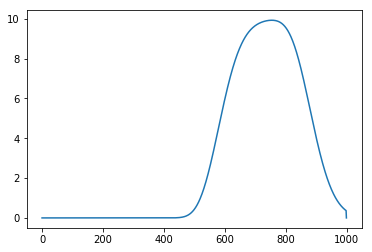

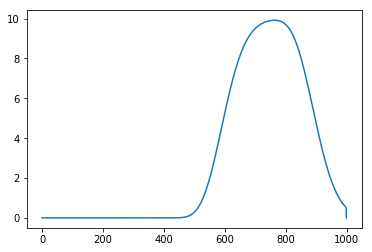

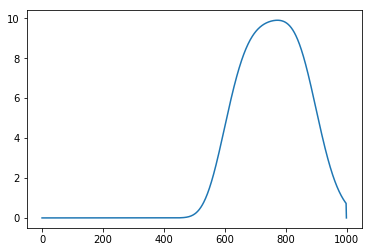

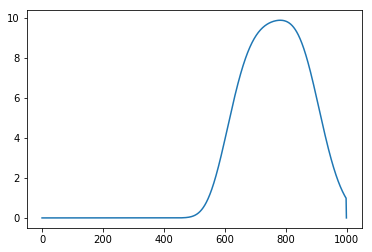

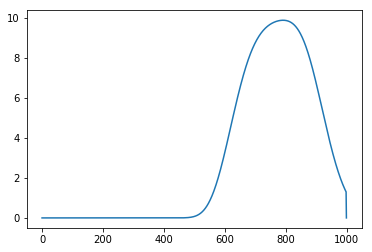

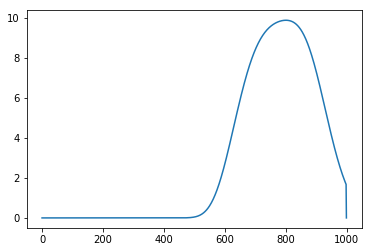

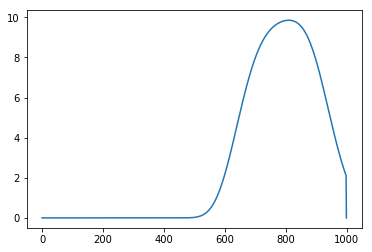

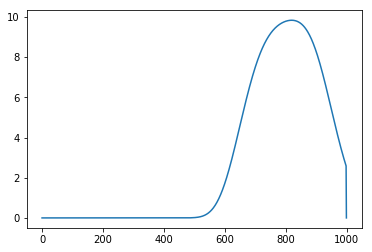

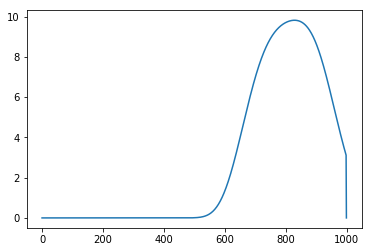

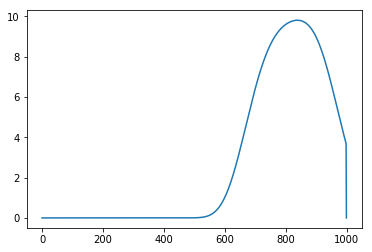

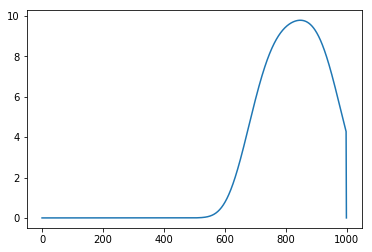

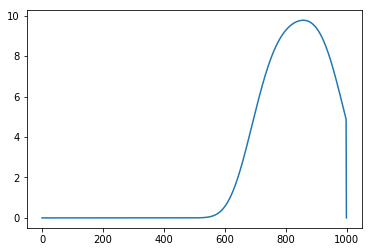

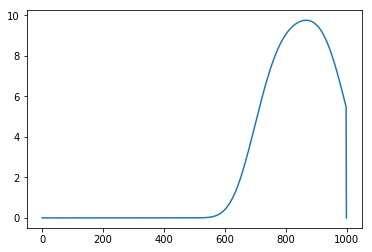

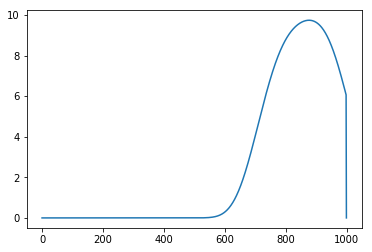

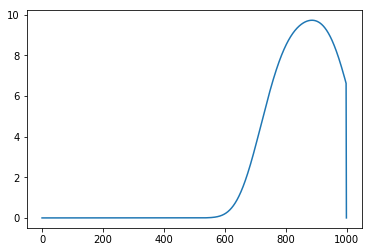

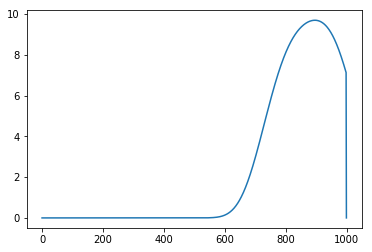

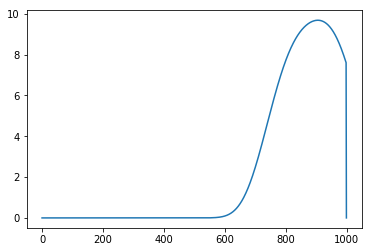

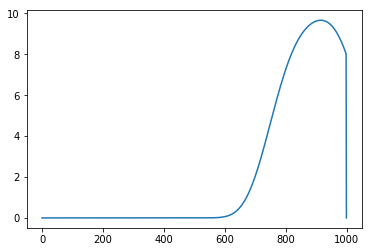

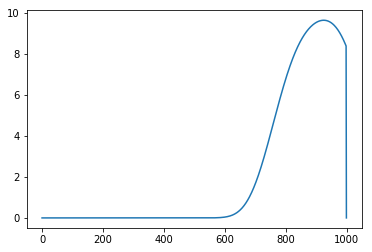

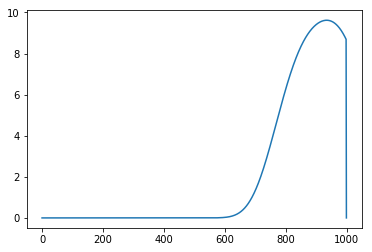

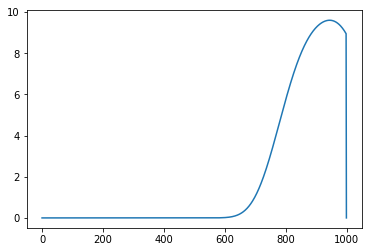

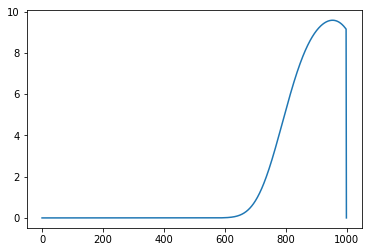

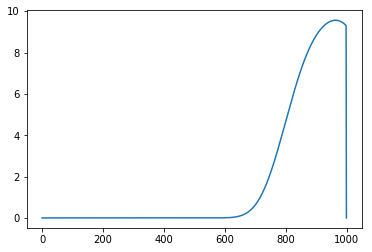

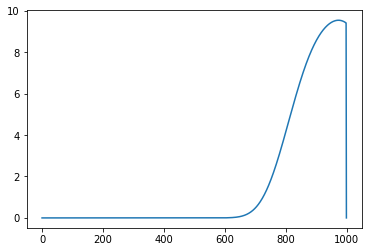

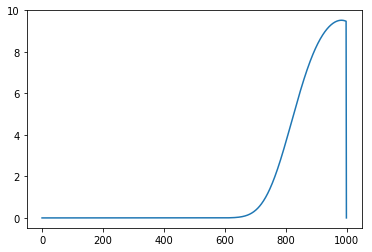

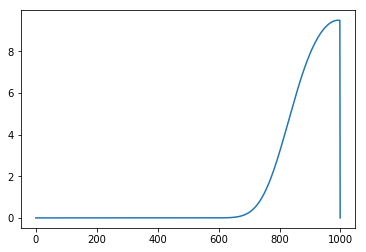

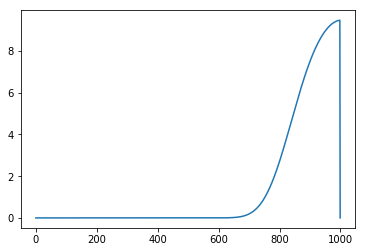

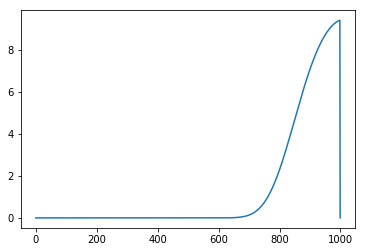

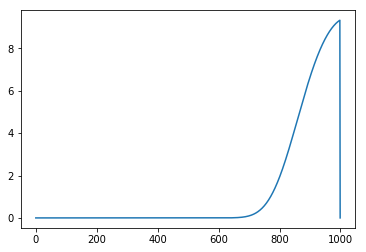

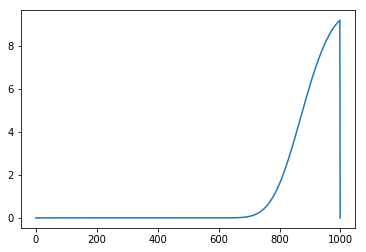

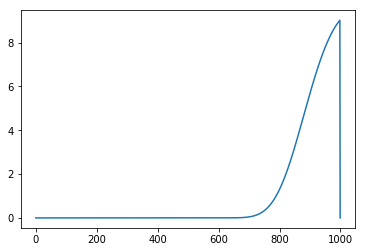

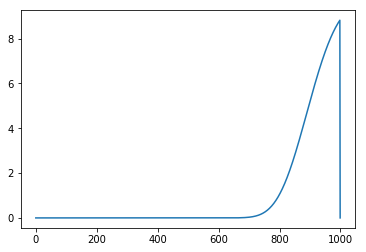

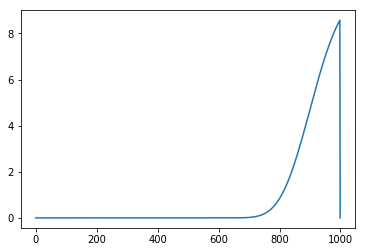

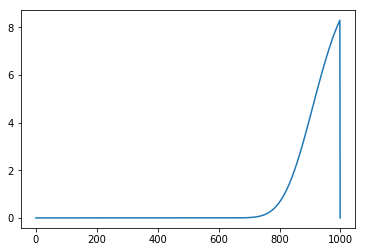

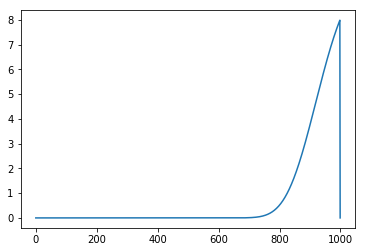

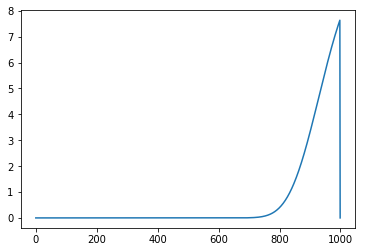

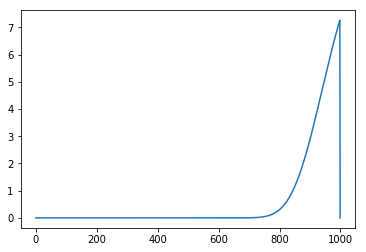

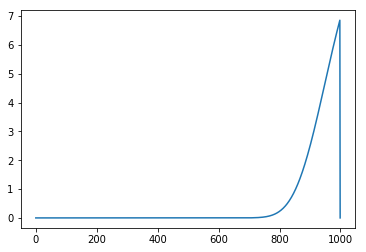

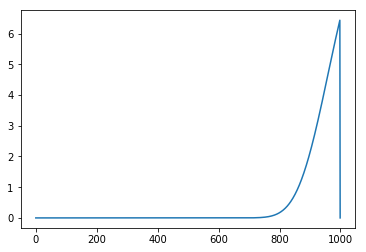

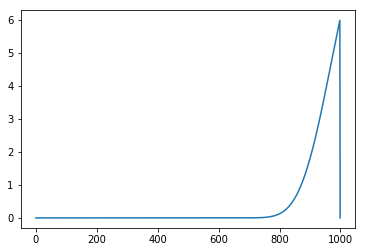

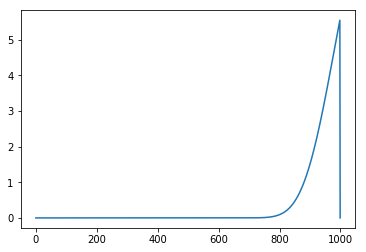

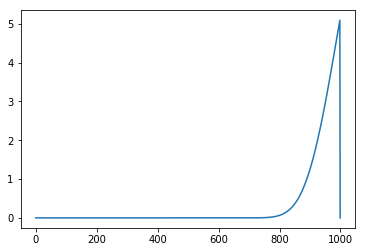

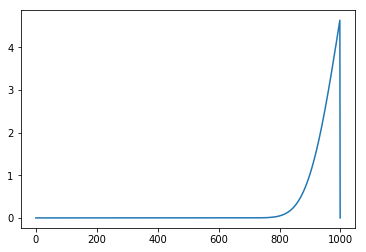

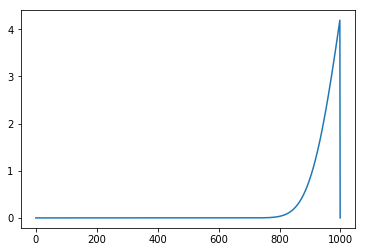

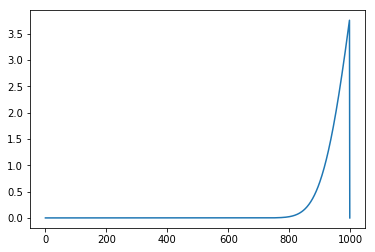

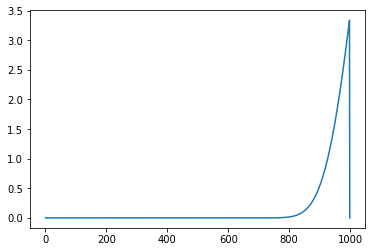

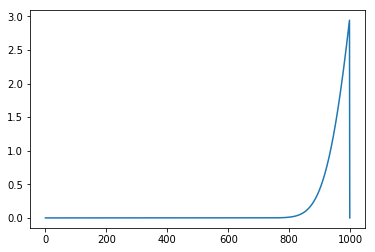

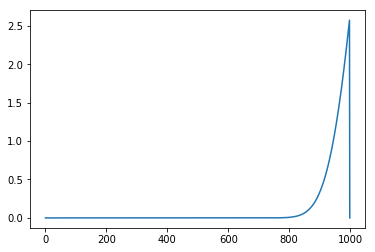

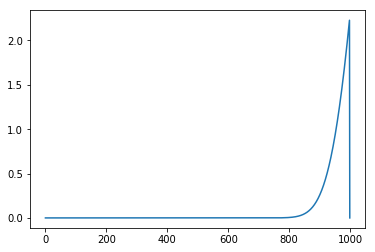

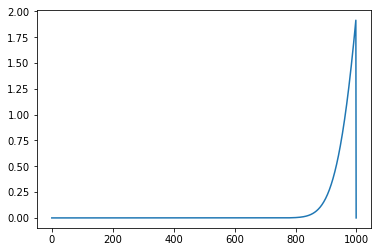

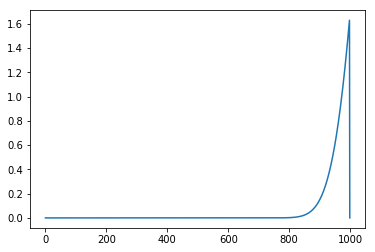

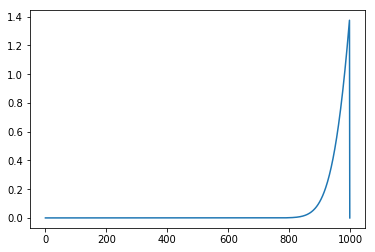

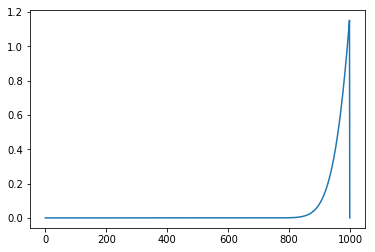

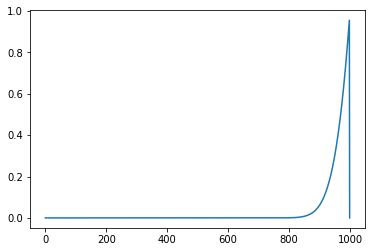

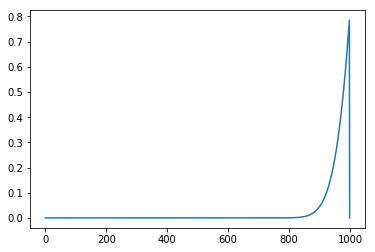

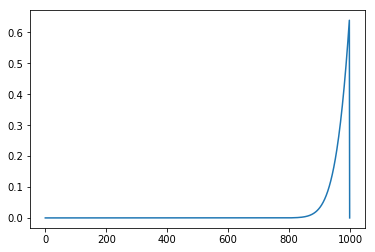

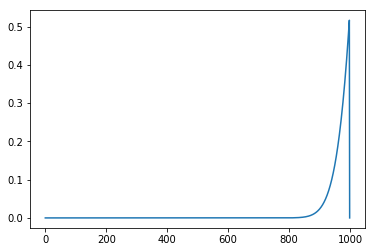

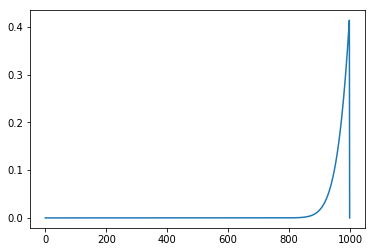

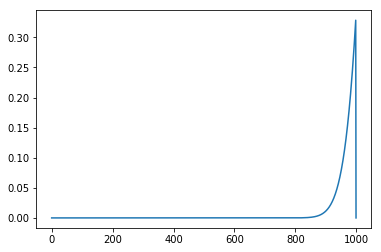

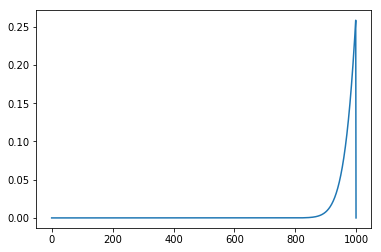

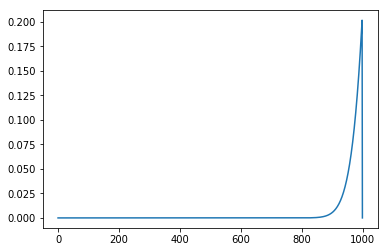

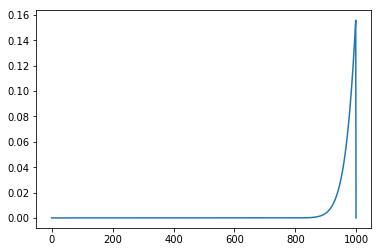

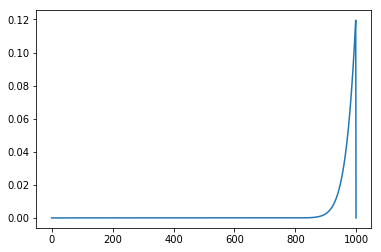

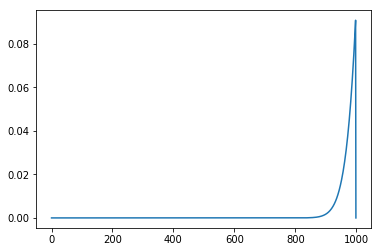

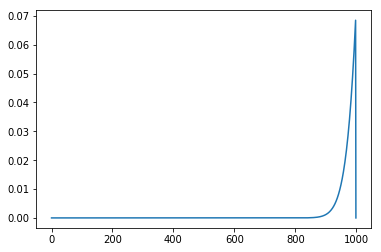

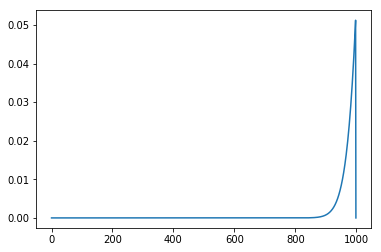

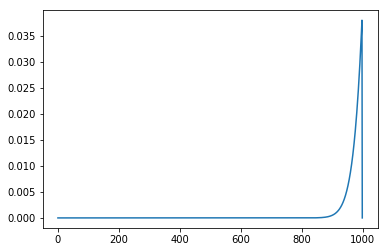

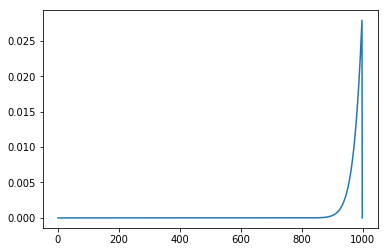

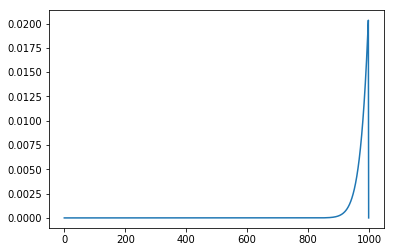

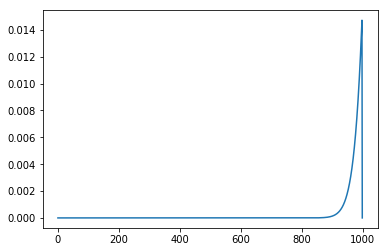

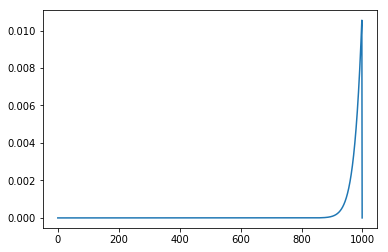

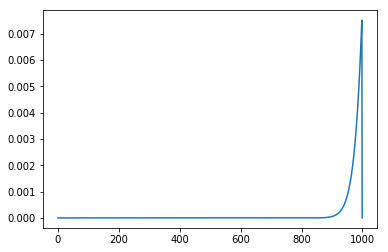

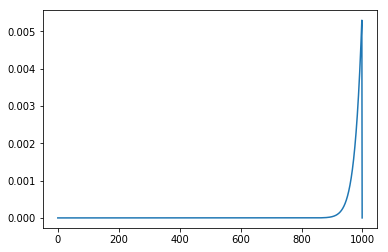

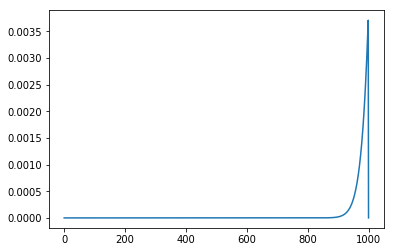

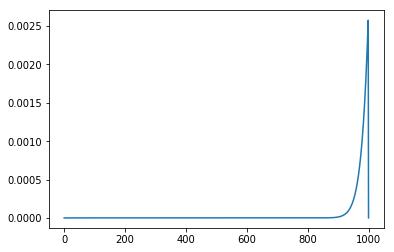

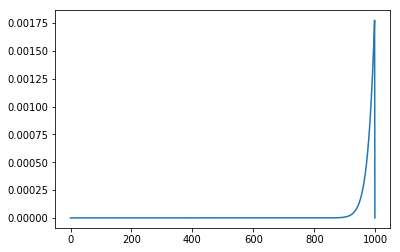

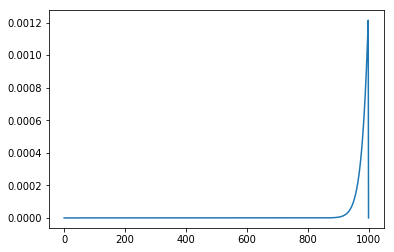

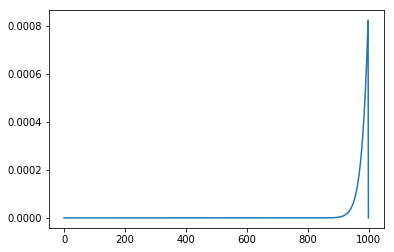

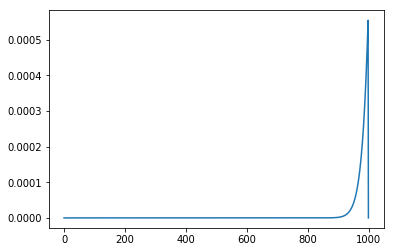

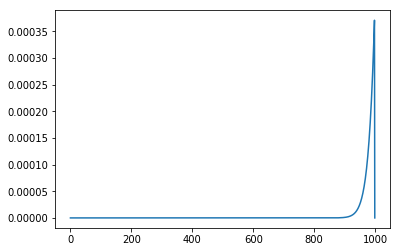

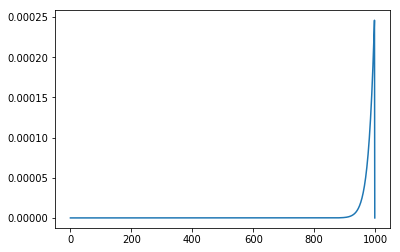

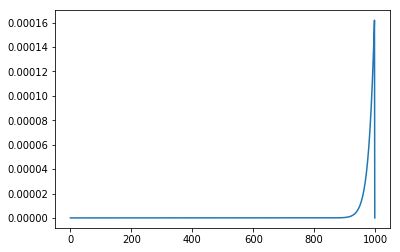

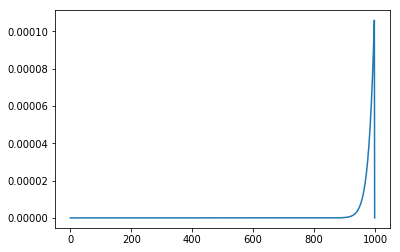

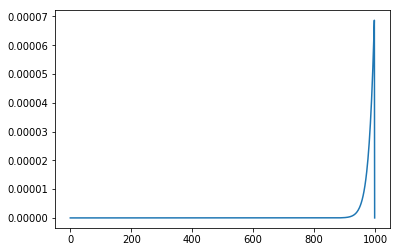

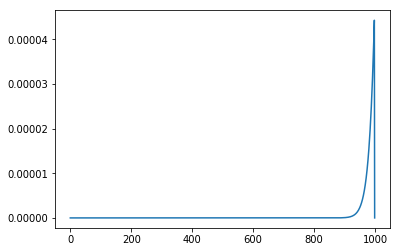

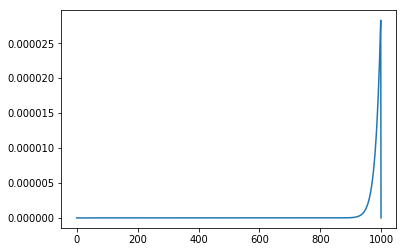

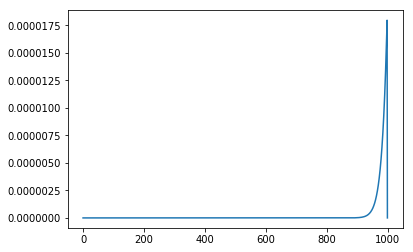

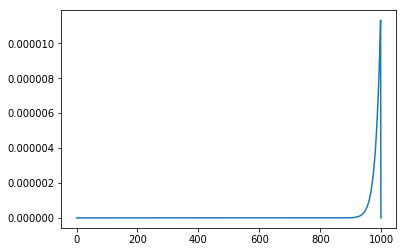

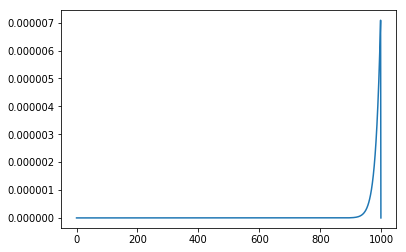

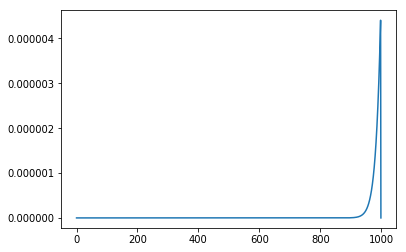

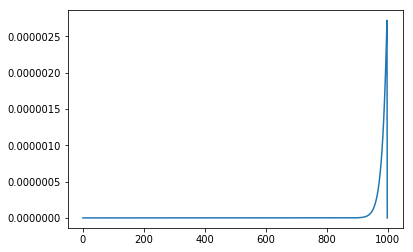

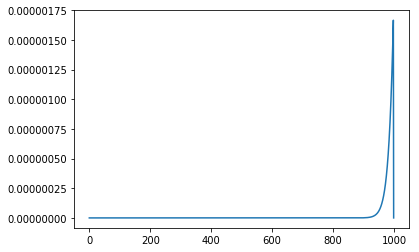

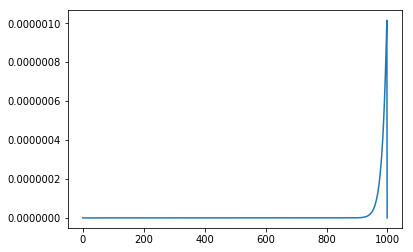

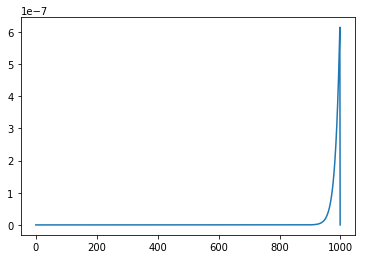

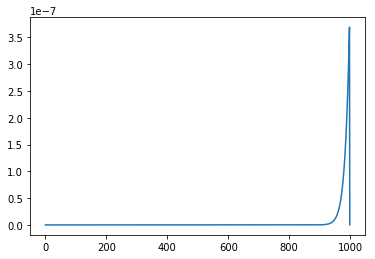

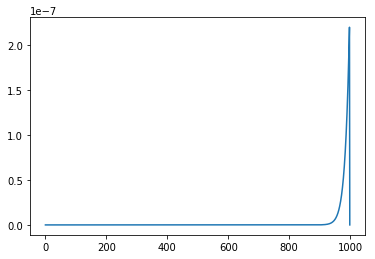

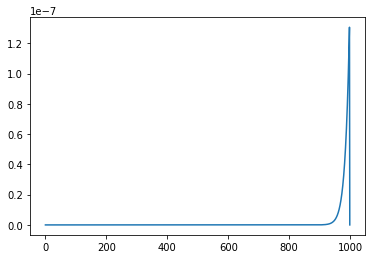

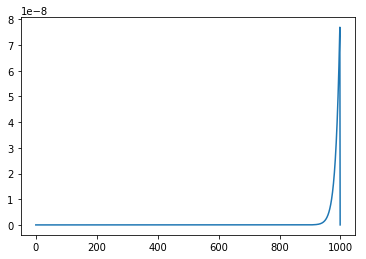

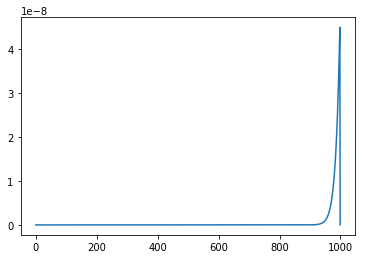

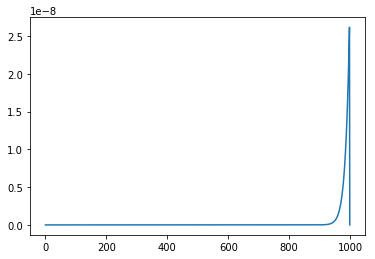

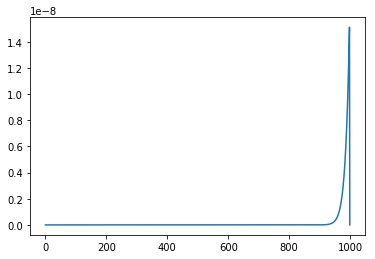

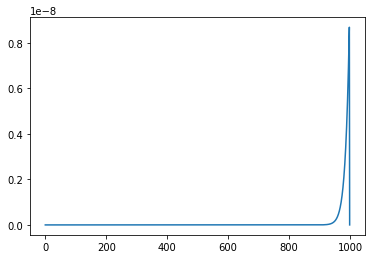

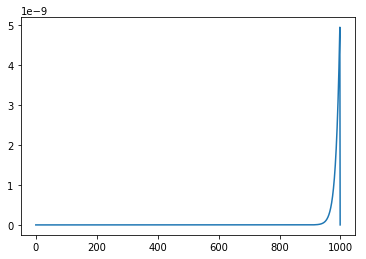

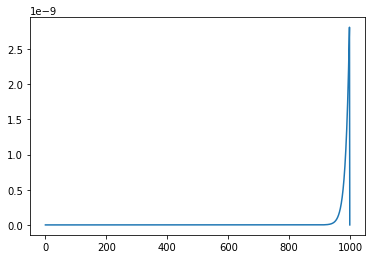

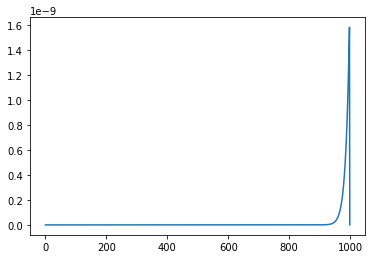

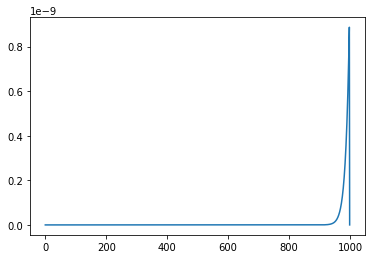

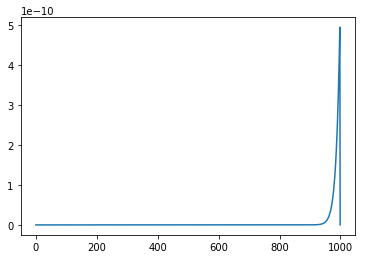

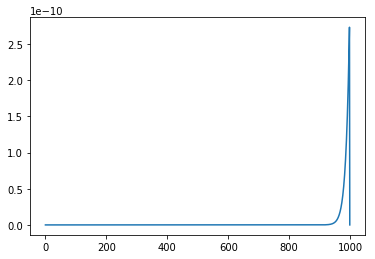

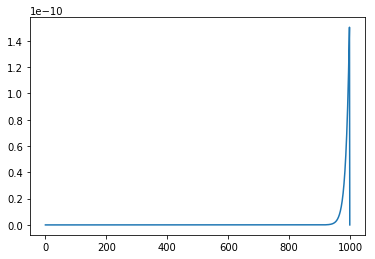

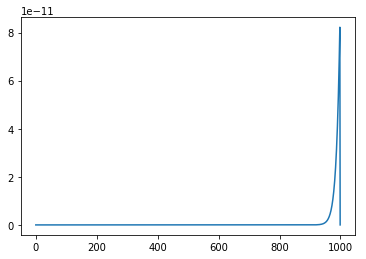

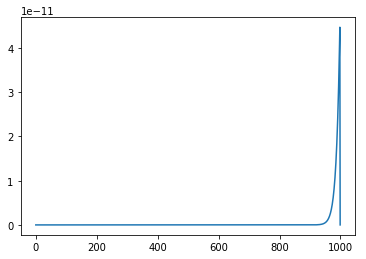

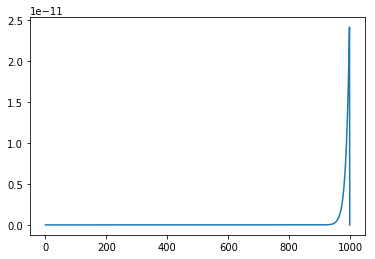

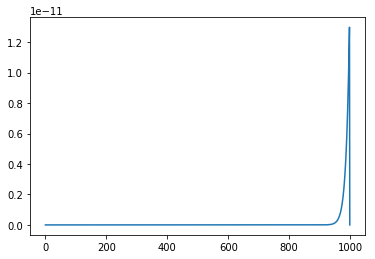

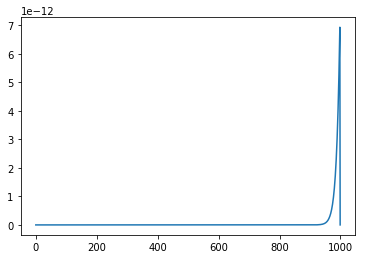

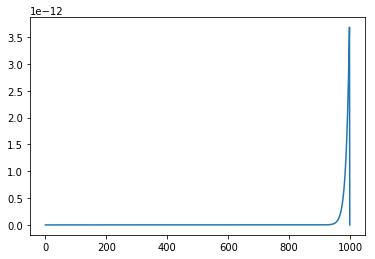

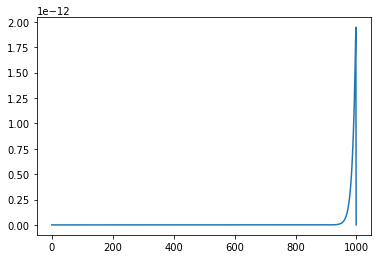

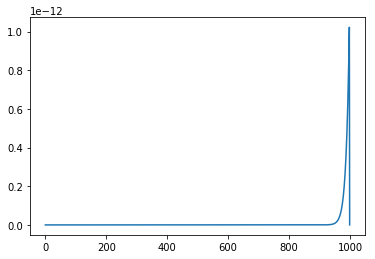

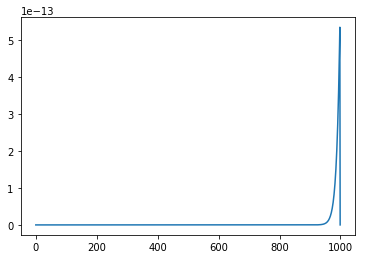

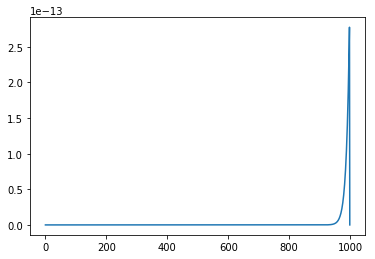

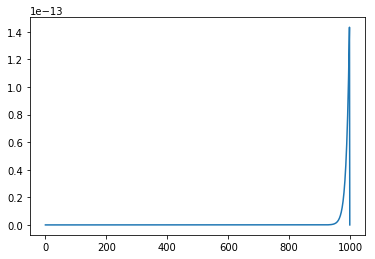

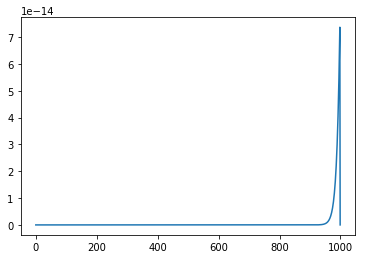

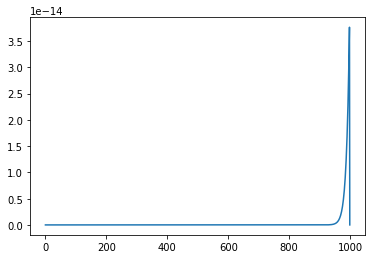

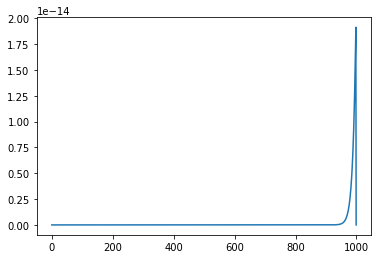

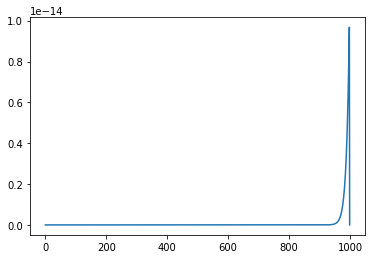

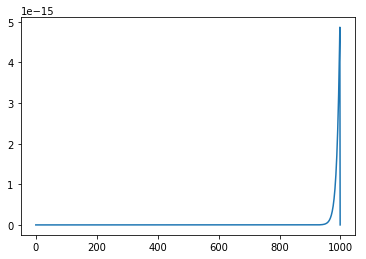

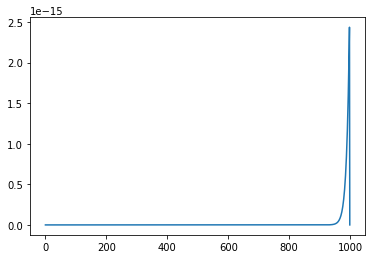

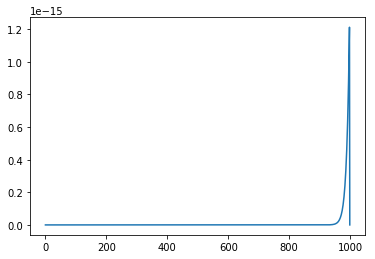

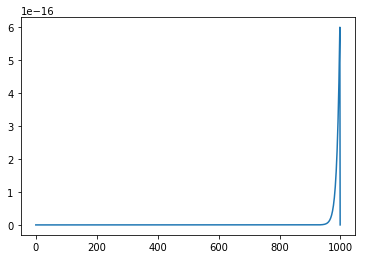

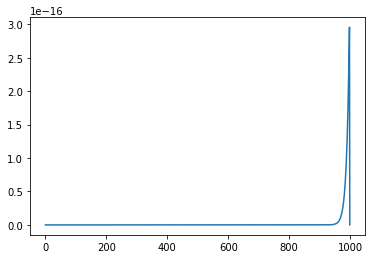

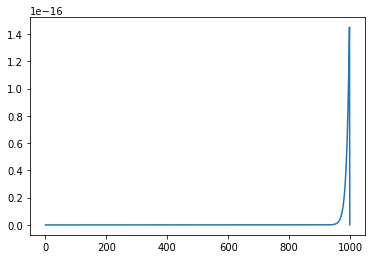

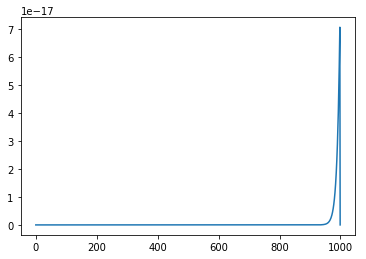

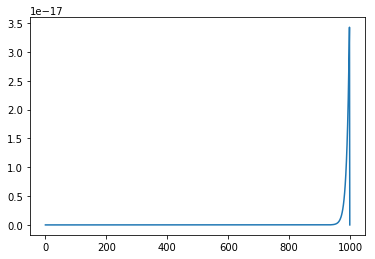

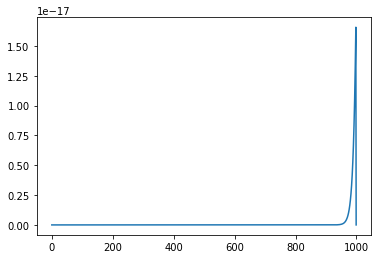

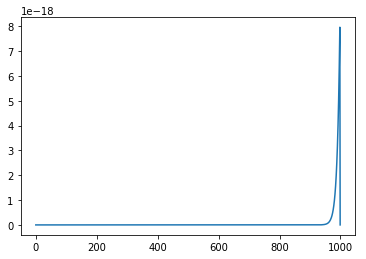

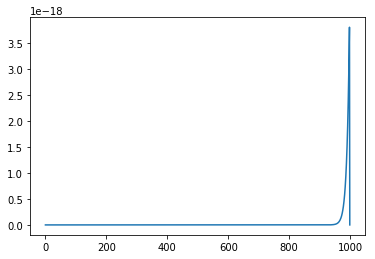

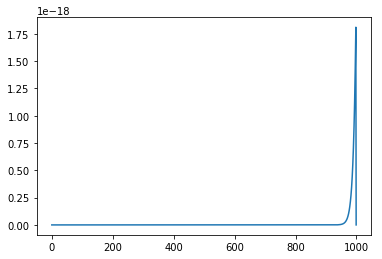

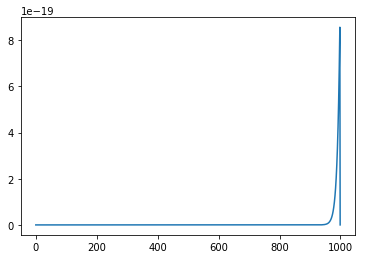

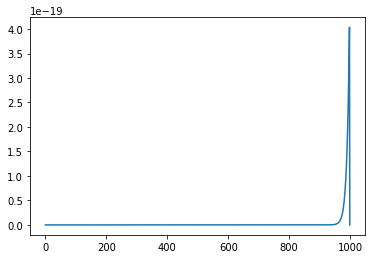

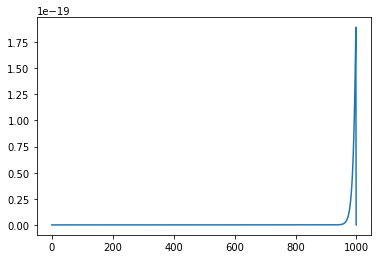

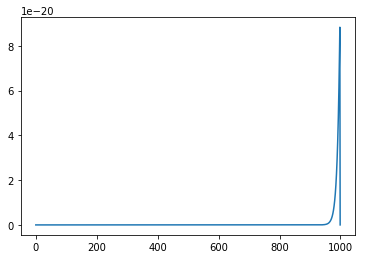

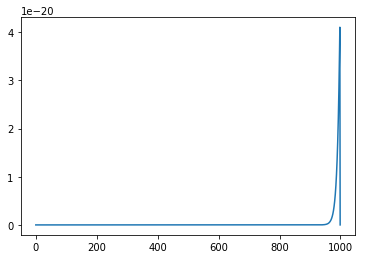

In [ ]:
timesteps=1000
dx=width/spacegrid
xx=np.arange(spacegrid)
dt=simulationtime/timesteps
rhoFxVar=np.zeros((timesteps,spacegrid),float)
rhoFxVar[0,300:600]=10
velocitygrid=10+0*np.ones(spacegrid)
difOperatorElectron1=SparseContinuityOperator22(dt,dx,veolcitygrid)
plt.plot(velocitygrid)
plt.show()
print(difOperatorElectron1.todense())
print(rhoFxVar.shape)
plt.plot(rhoFxVar[0])
for t in range(timesteps-1):
    rhoFxVar[t+1,1:-1]=la.spsolve(difOperatorElectron1,rhoFxVar[t])[1:-1].copy()
    plt.plot(rhoFxVar[t+1])
    plt.show()
#anim = animation.FuncAnimation(fig, animate, fargs=(rhoFxVar[:,1:-1],xx[1:-1],10,), init_func=init,frames=100, interval=20, blit=True)
#anim.save('continuity.gif', writer='imagemagick')
#Image(url='continuity.gif')

## Flux Corrected Transport

## Implicit Flux Corrected Transport